In [4]:
# !uv pip install langchain langgraph requests langchain-google-genai pygraphviz

### Setup and Dependencies

In [5]:
import os
from typing import TypedDict, Optional

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.prompts import ChatPromptTemplate

from langgraph.graph import StateGraph, END

# Set your Google API key (replace with your actual key or load from .env)
os.environ["GOOGLE_API_KEY"] = ""

# Initialize the Gemini model we'll use for all nodes
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0)

### Define AI Agent's State

In [6]:
class AgentState(TypedDict, total=False):
    query: str
    answer: Optional[str]
    critique: Optional[str]
    refined: Optional[str]
    decision: Optional[str]

### Define Prompts

In [7]:
generate_prompt = ChatPromptTemplate.from_template(
    "You are a helpful assistant. Answer the following query:\n\n{query}"
)

reflect_prompt = ChatPromptTemplate.from_template(
    "Here is the assistant's answer:\n\n{answer}\n\nPlease critique it and suggest improvements."
)

refine_prompt = ChatPromptTemplate.from_template(
    "Original answer:\n{answer}\n\nCritique:\n{critique}\n\nPlease provide a refined, improved answer."
)

decision_prompt = ChatPromptTemplate.from_template(
    "Here is the latest refined answer:\n\n{refined}\n\n"
    "Question: Is this answer sufficient and high-quality? "
    "Reply with only one word: 'yes' or 'no'."
)

# Chains together
generate_chain = generate_prompt | llm
reflect_chain = reflect_prompt | llm
refine_chain = refine_prompt | llm
decision_chain = decision_prompt | llm

### Define Node Function

In [8]:
def generate_node(state: AgentState):
    result = generate_chain.invoke({"query": state["query"]})
    state["answer"] = result.content
    return state

def reflect_node(state: AgentState):
    result = reflect_chain.invoke({"answer": state["answer"]})
    state["critique"] = result.content
    return state

def refine_node(state: AgentState):
    result = refine_chain.invoke({
        "answer": state["answer"],
        "critique": state["critique"]
    })
    state["refined"] = result.content
    return state

def decide_node(state: AgentState):
    result = decision_chain.invoke({"refined": state["refined"]})
    state["decision"] = result.content.strip().lower()
    return state

def decide_next(state: AgentState):
    if state.get("decision") == "yes":
        return END
    else:
        return "reflect"

### Build Graph

In [10]:
graph = StateGraph(AgentState)

# Add Node
graph.add_node("generate", generate_node)
graph.add_node("reflect", reflect_node)
graph.add_node("refine", refine_node)
graph.add_node("decide", decide_node)

# Set Entry Node
graph.set_entry_point("generate")

# Connect Node (Add a Arrow to connect A Node and B Node)
## "Generate" --> "Reflect"
graph.add_edge("generate", "reflect")
## "Reflect" --> "Refine"
graph.add_edge("reflect", "refine")
## "Refine" --> "decide"
graph.add_edge("refine", "decide")

# Conditional edge from "decide"
graph.add_conditional_edges("decide", decide_next)

# Compile
app = graph.compile()

### Run Agent

In [ ]:
inputs = {"query": "Why the image classifier have high accuracy but it fail to fulfill my expectation in classifying image. Please state in concise."}

for output in app.stream(inputs):
    for node, state in output.items():
        print(f"Output from node '{node}':")

        if node == "generate":
            print(state["query"])
            print(state["answer"])
            print()
        elif node == "reflect":
            print(state["critique"])
            print()
        elif node == "refine":
            print(state["refined"])
            print()
        elif node == "decide":
            print(state["decision"])
            print()

Output from node 'generate':
Why the image classifier have high accuracy but it fail to fulfill my expectation in classifying image. Please state in concise.
High accuracy is typically on a specific test set. Your model likely suffers from **poor generalization** or a **mismatch between its training data and your real-world application's diverse or specific image conditions.**

Output from node 'reflect':
The assistant's answer correctly identifies the core issues: **poor generalization** and a **mismatch between training and real-world data**. These are indeed the most common reasons for a model performing well on a test set but failing in production.

However, the answer is quite concise and could be significantly improved by:

1.  **Elaborating on the concepts:** Briefly explaining *what* poor generalization and data mismatch mean.
2.  **Providing actionable next steps/solutions:** The user is left with a diagnosis but no guidance on how to fix it.
3.  **Offering to ask for more inf

KeyError: 'decide'

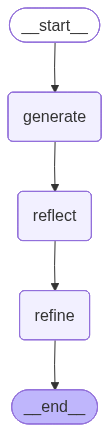

In [ ]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())